In [38]:
import json
import torch
import numpy as np
import sys
import os

from tqdm import tqdm

from rdkit import Chem, RDLogger

# Shut up RDKit
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw

sys.path.append('./SD_LSTM/')
sys.path.append('./LSTM/')
sys.path.append('./VANILLA_VAE/')
sys.path.append('./SD_VAE/')

from sd_vae_sampler import SDVAESampler
from model_sd_vae import SDVAE
from sd_lstm_sampler import SDLSTMSampler
from sd_lstm_utils import load_model as load_sd_lstm_model
from benchmark_vanilla_vae import VanillaVAEHarness
from model_vanilla_vae import VanillaMolVAE
from rnn_utils import load_model

from fast_rnn_sampler import FastSampler
# from rnn_sampler import ConditionalSmilesRnnSampler
from rnn_utils import load_rnn_model


sys.path.append('utils/')

from evaluation_utils import amina_metrics, property_metrics, props_from_smiles, plot_smiles, reconstruct_normalize

sys.path.append('../utils/')
from property_calculator import PropertyCalculator

pc = PropertyCalculator(['LogP'])

In [30]:
# Regularized Vanilla VAE

model_weights = '/home/chrome/Code/MolGen/my_code/models/REG_VAE_4_001/SD_REG_VANILLA_VAE_rapid-cloud-97_Epoch_10_Vl_0.900.pt'
model_definit = '/home/chrome/Code/MolGen/my_code/models/REG_VAE_4_001/SD_REG_VANILLA_VAE_rapid-cloud-97_Epoch_10_Vl_0.900.json'

reg_vae_sampler = VanillaVAEHarness(batch_size=64, device='cpu')
reg_vae_model = load_model(model_class=VanillaMolVAE, model_definition=model_definit, model_weights=model_weights, device='cpu')

# ugly hack
reg_vae_model = reg_vae_model.to('cpu')
reg_vae_model.device = 'cpu'
reg_vae_model.encoder.device = 'cpu'
reg_vae_model.state_decoder.device = 'cpu'

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [31]:
dataset_path = "data/QM9/"
qmds = pd.read_csv(os.path.join(dataset_path, 'QM9_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['QM9_id', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/QM9/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 2]]

Index(['QM9_id', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


In [32]:
prop_names = ['LogP']

In [33]:
def benchmark_reconstruction_QM9(model, sampler, test_smiles, test_props):
    test_props = torch.tensor([[float(a)] for a in test_props])

    print(test_props.shape)

    recon_smiles = sampler.reconstruct_smiles(model, test_smiles, test_props)

    assert len(recon_smiles) == len(test_smiles)

    same = 0
    junk = 0
    for i in range(len(recon_smiles)):
        if recon_smiles[i] == test_smiles[i]:
            same += 1
        if 'JUNK' in recon_smiles[i]:
            junk += 1
    
    acc = same / len(recon_smiles)
    junk_pct = junk / len(recon_smiles)
    print(f'Accuracy: { acc }')
    print(f'Junk PCT: { junk_pct }')

In [34]:
def return_valid_smiles(smiles_list):
    '''
    return smiles list with invalid smiles removed
    '''
    valid = []
    for smi in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                valid.append(smi)
        except:
            pass
    return valid

In [35]:
target_props = test_props
targets = torch.Tensor( [[a] for a in target_props])
num_to_sample = len(target_props)

In [36]:
reg_vae_global_sample_smiles = reg_vae_sampler.sample(model = reg_vae_model, properties=targets, num_to_sample=num_to_sample, max_seq_len=101)
assert(len(reg_vae_global_sample_smiles) == num_to_sample)
reg_vae_global_properties = props_from_smiles(reg_vae_global_sample_smiles)

  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/./VANILLA_VAE/model_vanilla_vae.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 10000/10000 [00:00<00:00, 20287.09it/s]


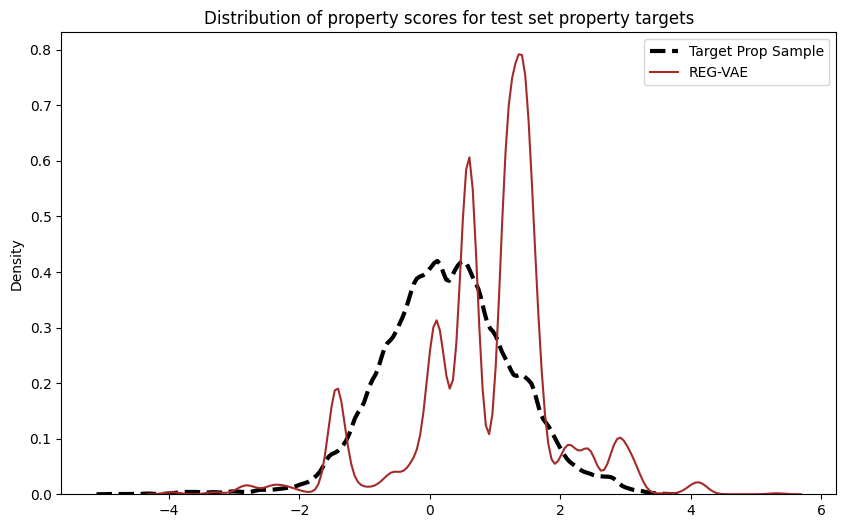

In [37]:
plt.figure(figsize=(10, 6))

sns.kdeplot(target_props, color="black", label='Target Prop Sample', bw_adjust=0.5, linestyle="--", linewidth=3 )
sns.kdeplot(reg_vae_global_properties, color = "brown", label='REG-VAE', bw_adjust=0.5)

plt.title(f'Distribution of property scores for test set property targets')# {pval0} : {pval1})')
plt.legend()
plt.show()

In [21]:
benchmark_reconstruction_QM9(reg_vae_model, reg_vae_sampler, test_smiles, test_props)

torch.Size([10000, 1])


  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/./VANILLA_VAE/model_vanilla_vae.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 157/157 [01:04<00:00,  2.45it/s]

Accuracy: 0.1121
Junk PCT: 0.0


In [22]:
reg_vae_metrics = amina_metrics(reg_vae_global_sample_smiles, train_smiles)

In [23]:
reg_vae_metrics

(0.7957, 0.008545934397385949, 1.0)

In [24]:
reg_vae_p_metrics = property_metrics(reg_vae_global_sample_smiles, targets, prop_names = ['LogP'])

In [25]:
reg_vae_p_metrics

([0.36439318205500815], [tensor(5.1021)])

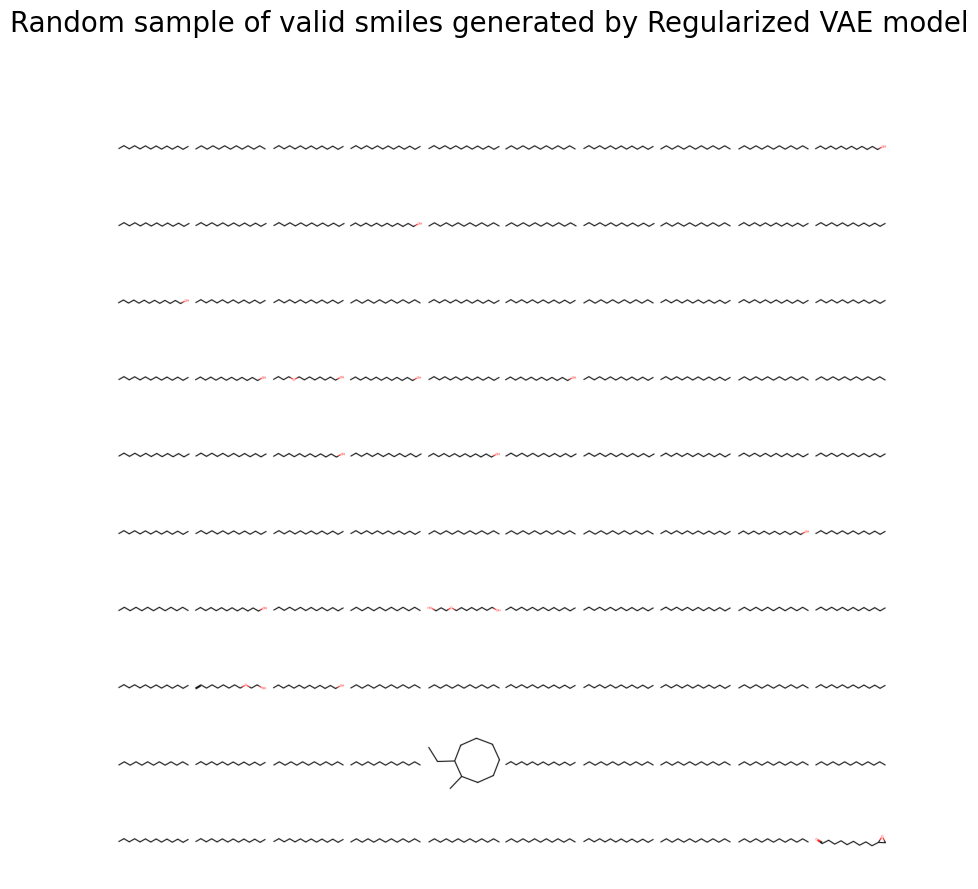

In [26]:
plot_smiles(reg_vae_global_sample_smiles, title="Random sample of valid smiles generated by Regularized VAE model")

In [37]:
property_steps = np.arange(-3, 3, 0.5)
samp_per_step = 500

reg_vae_steps_properties = []
reg_vae_steps_stats = {
    'Failed to decode':[],
    'Invalid Smiles':[],
    'Valid': []
}


for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = reg_vae_sampler.sample(model=reg_vae_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=101)
    missing = samp_per_step - len(smiles)
    valid_smiles = return_valid_smiles(smiles)
    invalid = (samp_per_step - missing) - len(valid_smiles)
    properties = props_from_smiles(valid_smiles)

    reg_vae_steps_properties.append(properties)
    reg_vae_steps_stats['Failed to decode'].append(missing)
    reg_vae_steps_stats['Invalid Smiles'].append(invalid)
    reg_vae_steps_stats['Valid'].append(samp_per_step - missing - invalid)

100%|██████████| 8/8 [00:02<00:00,  2.75it/s]]
0it [00:00, ?it/s]
100%|██████████| 8/8 [00:02<00:00,  2.87it/s]]
0it [00:00, ?it/s]
100%|██████████| 8/8 [00:02<00:00,  2.76it/s]]
0it [00:00, ?it/s]
100%|██████████| 8/8 [00:02<00:00,  2.81it/s]t]
0it [00:00, ?it/s]
100%|██████████| 12/12 [00:35<00:00,  2.95s/it]


/tmp/ipykernel_211010/1682271471.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(reg_vae_steps_properties[i], ax=ax, color='red', label='LSTM', bw_adjust=0.5)


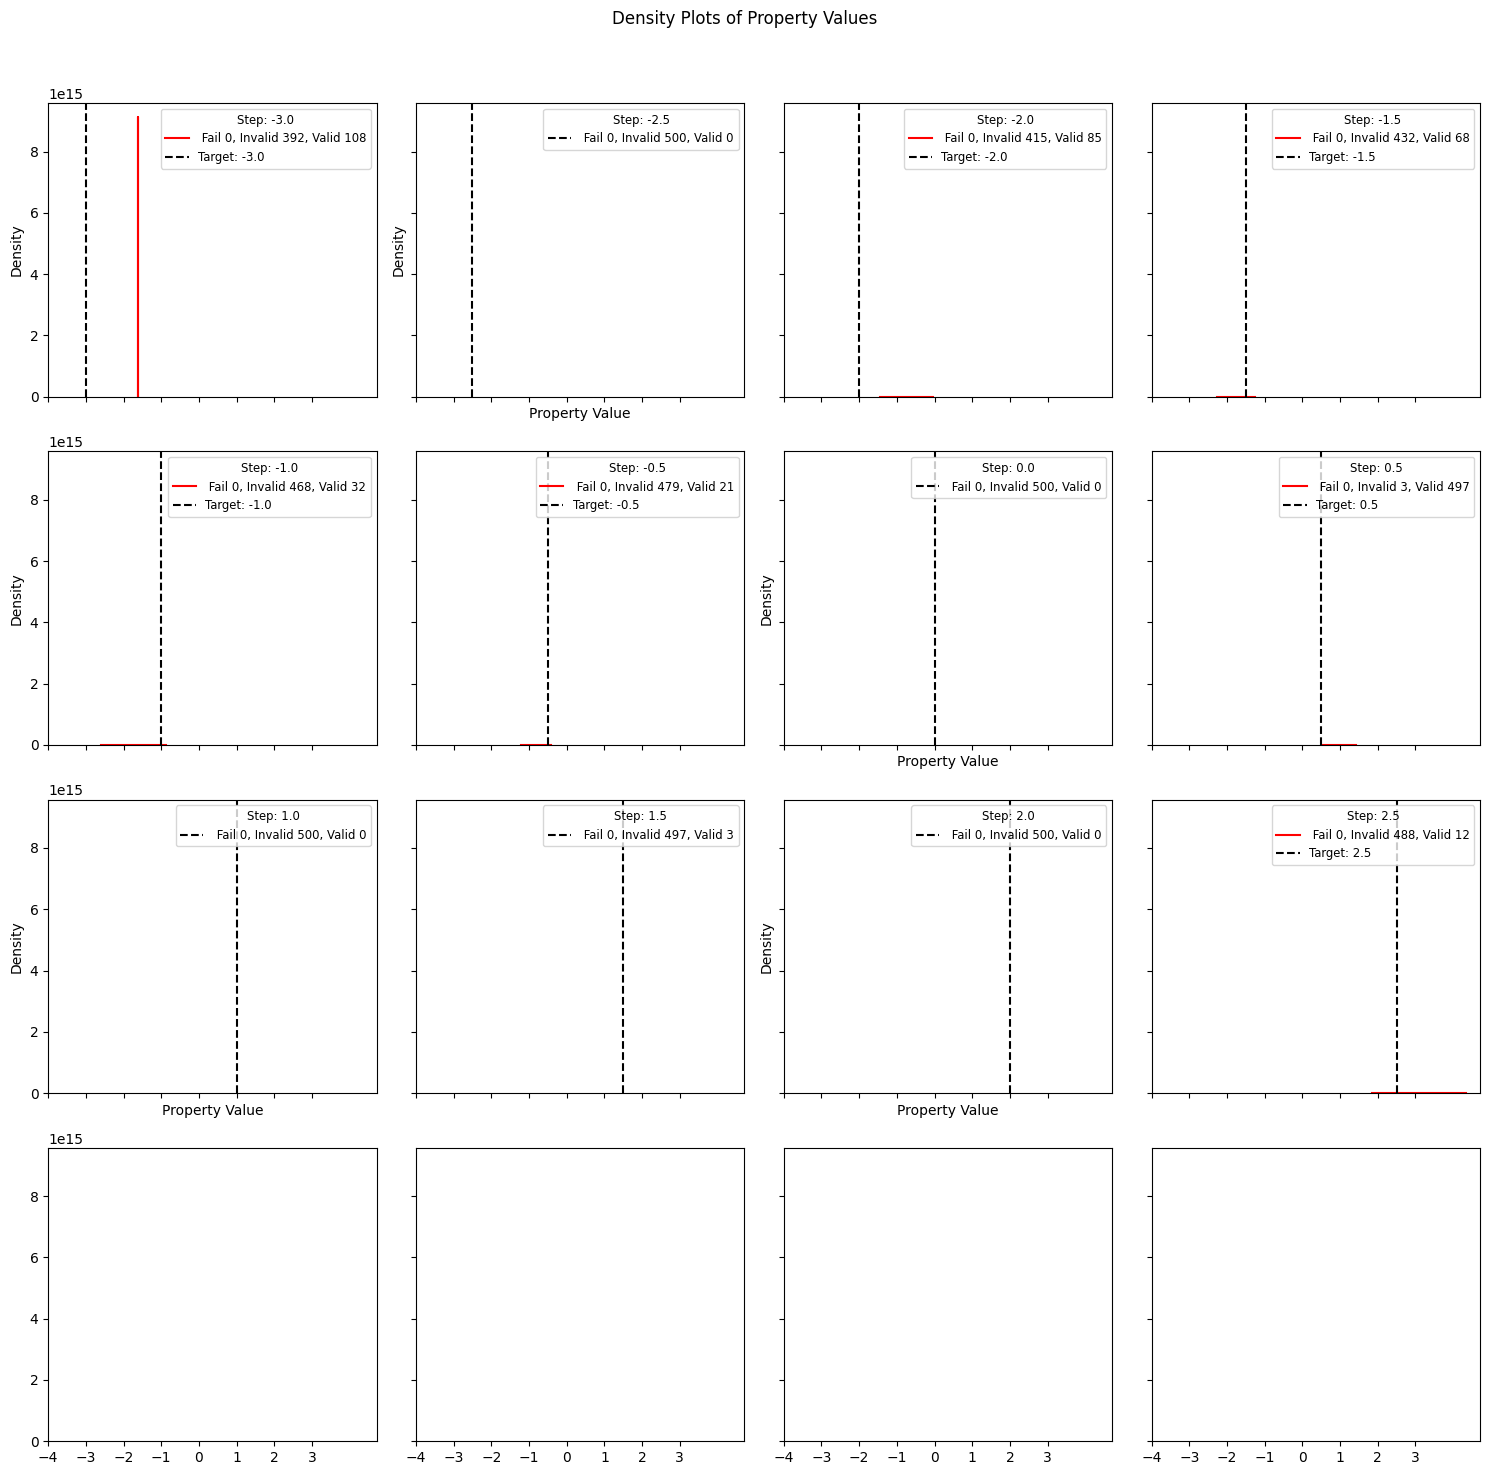

In [38]:
property_ticks = np.arange(-4, 4, 1)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Density Plots of Property Values')

# Flatten the axes for easy iteration
axes_flat = axes.flatten()

# Loop through each property step and create the corresponding plot
for i, p_val in enumerate(property_steps):
    ax = axes_flat[i]
    

    if reg_vae_steps_properties[i]:
        sns.kdeplot(reg_vae_steps_properties[i], ax=ax, color='red', label='LSTM', bw_adjust=0.5)


    # Vertical line for the target property value
    ax.axvline(x=p_val, color='black', linestyle='--', label=f'Target: {p_val}')

    # Define these values as per your data range and desired step
    ax.set_xticks(property_ticks)
    
    # Adding legend
    ax.legend(title=f'Step: {p_val}', loc='upper right', fontsize='small', title_fontsize='small', 
              labels=[
                  f' Fail {reg_vae_steps_stats["Failed to decode"][i]}, Invalid {reg_vae_steps_stats["Invalid Smiles"][i]}, Valid {reg_vae_steps_stats["Valid"][i]}',
                  f'Target: {p_val}'
              ])

    # Setting labels for each subplot
    ax.set_xlabel('Property Value')
    ax.set_ylabel('Density')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

# Show the plot
plt.show()